In [61]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import statistics
import _pickle as pickle
import json
import csv
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to C:\Users\Andrew
[nltk_data]     Sai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Andrew
[nltk_data]     Sai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
aita_df = pd.read_csv("reddit_aitaR.csv")
print("The size of the dataframe is {}.".format(aita_df.shape))
aita_df.head()

The size of the dataframe is (943, 16).


,Unnamed: 0,title,author,likes,comments,story,user_comment1,user_comment2,user_comment3,user_comment4,user_comment5,user_comment6,user_comment7,user_comment8,user_comment9,user_comment10
0,0,"UPDATE, AITA for despising my mentally handica...",Renegadesrule33,71.4k,2019,"I'm back like I said I would be,. My original ...","I'm back like I said I would be,. My original ...",Wow. OP's grandfather is a saint.\r\n,"Too right my guy, the sad thing is is that he ...",Reminds me of my wife's parents in a way. She...,This happened to an ex of mine. Her step fathe...,"That's a good story, always nice to hear a sto...","wait, you adopted your ex?\r\n","His parents did, while they were together in o...","Yes this, i was 16 at the time she was 15. Unl...",She's not like family. She's your sister. I'm ...
1,1,UPDATE: AITA for wanting to go to the funeral ...,sgdneyrother,63.8k,2,I want to sincerely thank everyone who comment...,I want to sincerely thank everyone who comment...,We've chosen to lock this update due to the hi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,META: Too many AITA commenters advocate too qu...,Cosmohumanist,52.7k,1646,I’ve become frustrated with how quick a lot of...,I’ve become frustrated with how quick a lot of...,Sometimes I'm surprised by how quickly people ...,Totally agree. And I absolutely appreciate the...,I think that it's only because the most logica...,Leaving a truly bad situation is necessary and...,\r\nMy issue is when we equate difficult with ...,I think a huge part of the problem is that if ...,The biggest lesson about love I’ve learned the...,"When people come to r/relationship_advice, the...",Thanks for taking that time for your reply.\r\...
3,3,AITA for telling my extended family how many m...,Thunderbear998,48.1k,5401,We had a family dinner this evening. My family...,We had a family dinner this evening. My family...,I think everything that needs to be said on ei...,ESH One person making personal attacks doesn’t...,"Yeah ESH seems right, not cool of her to be go...",I’ll never understand why people with bigger s...,It's possible that they don't think people wil...,"Some kind of ""too big to fail""? Their skeleton...",That’s a decent point that I hadn’t considered...,Bullies tend to think they are invulnerable ti...,"not necessarily the better person - just a ""co..."
4,4,AITA for despising my mentally handicap sister?,Renegadesrule33,46.2k,2764,The title makes me sound horrible but hear me ...,The title makes me sound horrible but hear me ...,If you want your comment to count toward judgm...,NTA. These are perfectly legitimate and unders...,"Hey, autistic guy here, can confirm that OP is...",Thank you for sharing and being so open! It so...,No problem at all! And i can kinda relate to h...,Hi! Former genetic engineering major here! Swi...,But you can cure autism by just not getting va...,LMAO I’m gonna be loving it if the “cure” is a...,Given what the commented said further up I can...


In [3]:
aita_df.isnull().sum()

Unnamed: 0        0
title             0
author            0
likes             0
comments          0
story             0
user_comment1     0
user_comment2     0
user_comment3     2
user_comment4     2
user_comment5     2
user_comment6     2
user_comment7     2
user_comment8     2
user_comment9     3
user_comment10    3
dtype: int64

In [4]:
aita_df[aita_df.isnull().any(axis=1)]

,Unnamed: 0,title,author,likes,comments,story,user_comment1,user_comment2,user_comment3,user_comment4,user_comment5,user_comment6,user_comment7,user_comment8,user_comment9,user_comment10
1,1,UPDATE: AITA for wanting to go to the funeral ...,sgdneyrother,63.8k,2,I want to sincerely thank everyone who comment...,I want to sincerely thank everyone who comment...,We've chosen to lock this update due to the hi...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
501,501,"Update! AITA for calling my brothers gf ""miss ...",Salt_Slip,8282,18,I just want to start by saying holy hell. I di...,I just want to start by saying holy hell. I di...,Getting way too close to reading like you're l...,[removed]\r\n,[removed]\r\n,[removed]\r\n,[removed]\r\n,[removed]\r\n,[removed]\r\n,NaN,NaN
671,671,UPDATE! AITA for not telling my boyfriend I kn...,secretivegfandsis,5603,2,Hey again guys! Thank you all so much for the ...,Hey again guys! Thank you all so much for the ...,Link to original. Because this involves violen...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
aita_df.fillna("No comments allowed", inplace=True)

In [6]:
aita_df['story_wordcount'] = aita_df.story.apply(lambda x: len(x.split()))

In [7]:
user_comment = []
for num in range(1,11):
    user_comment.append('user_comment{}_wordcount'.format(num))
counter = 0
for col in range(1, 11):
    aita_df['{}'.format(user_comment[counter])] = aita_df['user_comment{}'.format(col)].apply(lambda x: len(x.split()))
    counter += 1

In [8]:
def word_punc_digit_clean(word):
    word = ''.join([i for i in word if not i.isdigit()])    
    html_tags = re.compile('<.*?>')
    word = re.sub(html_tags, ' ', word)
    word = re.sub(r'[?|!|\'|#|%|^|&|.|,)|(|\|/|]|:', r'', word)
    word = word.replace('\r\n', ' ')
    return word

In [9]:
aita_df['story_clean'] = aita_df.story.apply(lambda x: word_punc_digit_clean(x))
aita_df['title_clean'] = aita_df.title.apply(lambda x: word_punc_digit_clean(x))

In [10]:
user_comment = []
for num in range(1,11):
    user_comment.append('user_comment{}_clean'.format(num))
counter = 0
for col in range(1, 11):
    aita_df['{}'.format(user_comment[counter])] = aita_df['user_comment{}'.format(col)].apply(lambda x: word_punc_digit_clean(x))
    counter += 1

In [11]:
aita_df['likes'] = aita_df.likes.apply(lambda x: x.replace('.', ''))
aita_df['likes'] = aita_df.likes.apply(lambda x: x.replace('k', '00'))
aita_df['likes'] = aita_df['likes'].astype(np.int64)

In [12]:
male_age_re = re.compile('\d\d[Mm]')
female_age_re = re.compile('\d\dF|m')
male_age = re.findall(male_age_re, aita_df['story'][3])
female_age = re.findall(female_age_re, aita_df['story'][3])

In [13]:
male_age_re = re.compile('\d\d[Mm]')
female_age_re = re.compile('\d\d[Ff]')
aita_df['male_age'] = aita_df['story'].apply(lambda x: re.findall(male_age_re, x))
aita_df['male_age'] = aita_df['male_age'].apply(lambda x: 0 if len(x)== 0 else x[0])
aita_df['female_age'] = aita_df['story'].apply(lambda x: re.findall(female_age_re, x))
aita_df['female_age'] = aita_df['female_age'].apply(lambda x: 0 if len(x)== 0 else x[0])
aita_df['male_age'] = aita_df['male_age'].apply(lambda x: re.sub(r'M|m', r'', str(x)))
aita_df['male_age'] = aita_df['male_age'].astype(np.int64)
aita_df['female_age'] = aita_df['female_age'].apply(lambda x: re.sub(r'F|f', r'', str(x)))
aita_df['female_age'] = aita_df['female_age'].astype(np.int64)

In [14]:
tokenizer = RegexpTokenizer(r'\w+')
aita_df['story_clean'] = aita_df['story'].apply(lambda x: tokenizer.tokenize(x.lower()))

In [15]:
def remove_stopwords(text):
    words = [word for word in text if word not in stopwords.words('english')]
    return words

In [16]:
aita_df['story_clean'] = aita_df['story_clean'].apply(lambda x: remove_stopwords(x))

In [17]:
lemmatizer = WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text = " ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

In [18]:
aita_df['story_clean'] = aita_df['story_clean'].apply(lambda x: word_lemmatizer(x))

In [55]:
wordlist = aita_df['story_clean'].str.split(expand = True).stack().value_counts().astype(int)

In [56]:
wordlist_dict = dict(wordlist)

In [57]:
format_wordlist_dict = {}
for keys, values in wordlist_dict.items():
    format_wordlist_dict[keys] = int(values)

In [58]:
format_wordlist = []
for keys, values in format_wordlist_dict.items():
    format_wordlist.append({'word': str(keys), 'size': str(values)})

In [62]:
word_df = pd.DataFrame(list(format_wordlist_dict.items()), columns=['word', 'frequency'])

In [26]:
format_wordlist

[{'word': 'like', 'size': '1488'},
 {'word': 'said', 'size': '1435'},
 {'word': 'told', 'size': '1405'},
 {'word': 'get', 'size': '1366'},
 {'word': 'time', 'size': '1234'},
 {'word': 'would', 'size': '1147'},
 {'word': 'year', 'size': '1058'},
 {'word': 'one', 'size': '1056'},
 {'word': 'want', 'size': '1054'},
 {'word': 'know', 'size': '1009'},
 {'word': 'friend', 'size': '983'},
 {'word': 'think', 'size': '918'},
 {'word': 'really', 'size': '894'},
 {'word': 'go', 'size': '859'},
 {'word': 'got', 'size': '855'},
 {'word': 'going', 'size': '793'},
 {'word': 'kid', 'size': '778'},
 {'word': 'thing', 'size': '743'},
 {'word': 'people', 'size': '742'},
 {'word': 'day', 'size': '731'},
 {'word': 'wife', 'size': '720'},
 {'word': 'say', 'size': '715'},
 {'word': 'family', 'size': '704'},
 {'word': 'even', 'size': '698'},
 {'word': 'make', 'size': '685'},
 {'word': 'asked', 'size': '684'},
 {'word': 'feel', 'size': '681'},
 {'word': 'back', 'size': '676'},
 {'word': 'since', 'size': '635'}

In [40]:
with open('wordlist.tsv', 'w', encoding = 'utf-8') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    tsv_output.writerow(format_wordlist)

In [48]:
text = " ".join(words for words in aita_df['story_clean'])

In [52]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)

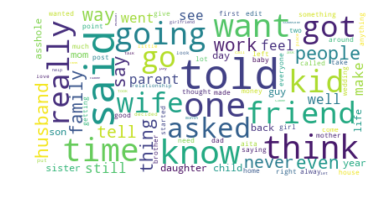

In [53]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [80]:
wordcloud.to_file('wordcloud.png')

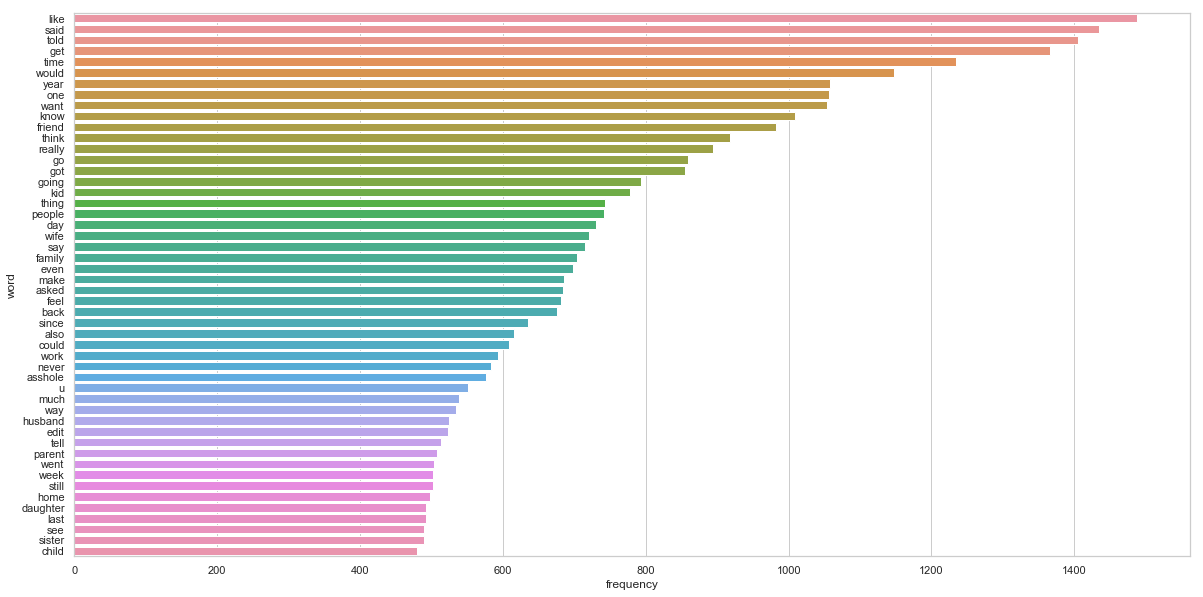

In [76]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 10))
sns_plot = sns.barplot(x="frequency", y="word", data=word_df[:50])

In [79]:
sns_plot.figure.savefig("wordbar.png")